In [1]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import numpy as np
from tqdm import tqdm

def get_cols_inf(df):
    """
    Returns a list of column names that contain positive or negative infinity.
    """
    return df.columns[np.isinf(df.values).any(axis=0)].tolist()

def get_cols_zerostd(df):
    """
    Returns a list of column names with zero standard deviation (excluding NaNs).
    """
    nunique_non_nan = df.nunique(dropna=True)
    return nunique_non_nan[nunique_non_nan <= 1].index.tolist()

def get_nan_columns(df):
    """
    Returns a list of column names that contain NaN values.
    """
    return df.columns[df.isna().any()].tolist()

def preprocess_train(train, columns_to_drop=[]):
    df = train.copy()
    
    #### Preprocessing
    # Identify once at the start
    cols_inf = get_cols_inf(df)
    print("Columns with infinite values:", cols_inf)
    cols_nan = get_nan_columns(df)
    print("Columns with NaN values:", cols_nan)
    cols_zerostd = get_cols_zerostd(df)
    print("Columns with zero standard deviation:", cols_zerostd)
    # Drop all at once
    cols_to_drop = set(cols_inf) | set(cols_nan) | set(cols_zerostd)

    df = df.drop(columns=cols_to_drop)

    #### Feature Engineering

    df.loc[:, 'bidask_ratio'] = df['bid_qty'] / df['ask_qty']
    df.loc[:, 'buysell_ratio'] = np.where(df['volume'] == 0, 0, df['buy_qty'] / df['sell_qty'])

    # df.loc[:, 'buysell_ratio_shift1'] = df['buysell_ratio'].shift(-1)

    df.loc[:, 'bidask_delta'] = df['bid_qty'] - df['ask_qty']
    df.loc[:, 'buysell_delta'] = df['buy_qty'] - df['sell_qty']

    df.loc[:, 'buysell_size'] = df['buy_qty'] + df['sell_qty']
    df.loc[:, 'bidask_size'] = df['bid_qty'] + df['ask_qty']

    # Final Drop
    df = df.drop(columns=columns_to_drop)
    return df

def evaluate_model(y_true, y_pred, X=None, linear=False, verbose=True):
    """
    General evaluation of regression models.
    Inputs:
        y_true: True target values
        y_pred: Predicted target values
        X: Feature matrix (optional, for adj_r2 and n_features)
        linear: If True, AIC and BIC will be computed (meaningful for linear models only)
        verbose: Print the results

    Outputs (dict):
        n_obs: Number of observations
        n_features: Number of features (if X provided)
        r2: R^2 score
        adj_r2: Adjusted R^2 (only if X is provided)
        rmse: Root Mean Squared Error
        mae: Mean Absolute Error
        medae: Median Absolute Error
        pearson_corr, pearson_pvalue
        spearman_corr, spearman_pvalue
        aic: Akaike Information Criterion (only if linear=True and X provided)
        bic: Bayesian Information Criterion (only if linear=True and X provided)
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    n_obs = len(y_true)
    n_features = X.shape[1] if X is not None else None

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    pearson_corr, pearson_p = pearsonr(y_true, y_pred)
    spearman_corr, spearman_p = spearmanr(y_true, y_pred)
    adj_r2 = (
        1 - (1 - r2) * (n_obs - 1) / (n_obs - n_features - 1)
        if X is not None and n_obs > n_features + 1 else np.nan
    )

    if linear and X is not None:
        n_params = n_features + 1  # +1 for intercept
        rss = np.sum((y_true - y_pred)**2)
        aic = n_obs * np.log(rss / n_obs) + 2 * n_params
        bic = n_obs * np.log(rss / n_obs) + n_params * np.log(n_obs)
    else:
        aic = np.nan
        bic = np.nan

    results = {
        "n_obs": n_obs,
        "n_features": n_features,
        "r2": r2,
        "adj_r2": adj_r2,
        "rmse": rmse,
        "mae": mae,
        "medae": medae,
        "pearson_corr": pearson_corr,
        "pearson_pvalue": pearson_p,
        # "spearman_corr": spearman_corr,
        # "spearman_pvalue": spearman_p,
        "aic": aic,
        "bic": bic,
    }

    if verbose:
        print(f"Observations:            {n_obs}")
        if n_features is not None:
            print(f"Features:                {n_features}")
        print(f"R^2:                     {r2:.5f}")
        print(f"Adjusted R^2:            {adj_r2:.5f}")
        print(f"RMSE:                    {rmse:.5f}")
        print(f"MAE:                     {mae:.5f}")
        print(f"Median Absolute Error:   {medae:.5f}")
        print(f"Pearson Corr:            {pearson_corr:.5f} (p={pearson_p:.3g})")
        print(f"Spearman Corr:           {spearman_corr:.5f} (p={spearman_p:.3g})")
        if linear and X is not None:
            print(f"AIC:                     {aic:.2f}")
            print(f"BIC:                     {bic:.2f}")
    return results

from sklearn.model_selection import TimeSeriesSplit

def sklearn_timeseries_split(X, n_splits=5, **kwargs):
    tscv = TimeSeriesSplit(n_splits=n_splits, **kwargs)
    for train_idx, test_idx in tscv.split(X):
        yield train_idx, test_idx

def evaluate_grid(X, y, params_data, params_split, params_model, is_linear=False, metric_func=evaluate_model):
    all_results = []

    # Calculate total iterations for tqdm progress bar
    total_iters = len(params_data) * len(params_split) * len(params_model)

    with tqdm(total=total_iters, desc="Total Model Runs") as pbar:
        for data_key, data_val in params_data.items():
            mask = (X.index >= data_val['start']) & (X.index <= data_val['end'])
            X_window = X.loc[mask]
            y_window = y.loc[mask]

            for split_key, split_val in params_split.items():
                splitter_func = split_val['splitter_func']
                splitter_args = split_val['splitter_args']
                splits = list(splitter_func(X_window, **splitter_args))

                for model_key, model_val in params_model.items():
                    model_func = model_val['model_func']
                    model_args = model_val['model_args']

                    split_results = []

                    for i, (train_idx, test_idx) in enumerate(splits):
                        X_train, X_test = X_window.iloc[train_idx], X_window.iloc[test_idx]
                        y_train, y_test = y_window.iloc[train_idx], y_window.iloc[test_idx]

                        model = model_func(X_train, y_train, **model_args)
                        y_pred = model.predict(X_test)
                        metric_dict = metric_func(y_test, y_pred, X=X_test, linear=is_linear, verbose=False)
                        metric_dict['split_num'] = i
                        split_results.append(metric_dict)

                    split_df = pd.DataFrame(split_results)
                    metrics_to_agg = [col for col in split_df.columns if col != "split_num"]
                    overall_results = split_df[metrics_to_agg].mean().to_dict()
                    model_output = {
                        "data_key": data_key,
                        "split_key": split_key,
                        "model_key": model_key,
                        **overall_results,
                        "n_splits": len(split_df),
                    }
                    all_results.append(model_output)
                    pbar.update(1)
    return all_results

# Data

In [3]:
data = pd.read_parquet('data/train.parquet')
y = data['label']
X = preprocess_train(data, columns_to_drop=['label', 'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty'])
X = X.sort_index(ascending=True)
X

Columns with infinite values: ['X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716', 'X717']
Columns with NaN values: []
Columns with zero standard deviation: ['X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716', 'X717', 'X864', 'X867', 'X869', 'X870', 'X871', 'X872']


,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X887,X888,X889,X890,bidask_ratio,buysell_ratio,bidask_delta,buysell_delta,buysell_size,bidask_size
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,0.027359,0.035780,0.068219,1.034825,...,0.377630,0.210153,0.159183,0.530636,1.814006,3.921505,6.858,131.421,221.389,23.708
2023-03-01 00:01:00,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,0.208359,0.217057,0.249624,0.948694,...,0.374515,0.209573,0.158963,0.530269,16.519692,1.633316,36.254,203.896,847.796,40.926
2023-03-01 00:02:00,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,0.072778,0.081564,0.114166,0.896459,...,0.371424,0.208993,0.158744,0.529901,0.007336,1.167619,-59.808,22.858,295.596,60.692
2023-03-01 00:03:00,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,-0.021681,-0.012936,0.019634,0.732634,...,0.368358,0.208416,0.158524,0.529534,0.231490,2.686731,-16.151,210.779,460.705,25.881
2023-03-01 00:04:00,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,0.078976,0.087818,0.120426,0.763537,...,0.365314,0.207839,0.158304,0.529167,7.869603,2.216115,23.707,54.004,142.818,30.609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 23:55:00,94.388,0.020155,0.076565,0.228994,0.288856,0.151634,0.108347,0.088073,0.073729,0.071211,...,0.393726,0.212651,0.136494,0.243172,0.611756,0.705263,-2.642,-16.314,94.388,10.968
2024-02-29 23:56:00,177.372,0.016262,0.062527,0.214072,0.276463,0.146521,0.104164,0.084063,0.069788,0.024066,...,0.390476,0.212063,0.136305,0.243004,0.564317,1.640604,-1.768,43.030,177.372,6.348
2024-02-29 23:57:00,101.252,0.045407,0.109834,0.263577,0.329266,0.174214,0.132940,0.113052,0.098865,-0.057370,...,0.387252,0.211477,0.136117,0.242836,1.438736,2.292427,1.597,39.746,101.252,8.877


In [8]:
X.shape

(525887, 870)

# Model: RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def fit_random_forest(X, y, n_estimators=100, max_features='auto', **kwargs):
    """Random Forest: bagging + random feature subsets for decorrelation"""
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_features=max_features,
        **kwargs
    )
    model.fit(X, y)
    return model

## Model: PLS

PLS seeks weight vectors $w$ and $q$ solving

$$
\max_{w,q}\;\mathrm{Cov}(Xw,\;yq)
\quad\text{s.t.}\quad \|w\|=\|q\|=1,
$$

then deflates $X$ and $y$ to extract subsequent components.  In practice one fits

$$
T = XW,\quad U = yQ,\quad\text{with}\;W = [w_1,\dots,w_k],\;Q=[q_1,\dots,q_k],
$$

and regresses $y$ on $T$.

In [ ]:
from sklearn.cross_decomposition import PLSRegression

def fit_pls(X, y, n_components):
    """
    Fits a PLS regression model with n_components latent variables.
    Returns the fitted model and transformed scores T = X @ W.
    """
    pls = PLSRegression(n_components=n_components)
    T = pls.fit_transform(X, y)[0]   # returns (X_scores, y_scores)
    return pls, T

# Feature Reduction

After the disappointing results on 27/05/2025, the next steps to improve were the features of the model.

```
    "d4": {
        "start": pd.Timestamp('2023-12-01 00:00:00'),
        "end":   pd.Timestamp('2024-02-29 23:59:00')
    }

    "ts1": {
        "splitter_func": sklearn_timeseries_split,
        "splitter_args": {"n_splits": 5}
    },
```

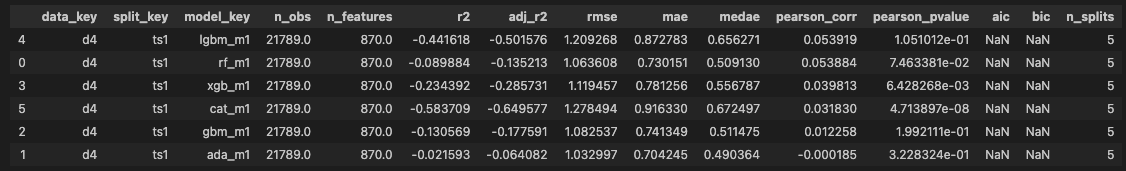

## 1 Filter

In [ ]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression

# 1a. Variance Thresholding: remove features with variance < 0.01
# drop any feature whose variance (i.e. its sample variance computed over all rows) is less than 0.1.
variance_thresholds = [0.01, 0.05, 0.1, 0.2]
for threshold in variance_thresholds:
    vt = VarianceThreshold(threshold=threshold)
    X_var = vt.fit_transform(X)  # X is your n×p feature matrix
    # boolean mask of kept columns
    mask = vt.get_support()
    # dropped columns
    dropped_cols = X.columns[~mask]
    print(f"Dropped columns for threshold {threshold}: {list(dropped_cols)}")


Dropped columns for threshold 0.01: []
Dropped columns for threshold 0.05: ['X184', 'X186', 'X187', 'X190']
Dropped columns for threshold 0.1: ['X156', 'X180', 'X183', 'X184', 'X185', 'X186', 'X187', 'X188', 'X190', 'X191', 'X432', 'X435', 'X438']
Dropped columns for threshold 0.2: ['X22', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X56', 'X58', 'X70', 'X79', 'X82', 'X84', 'X91', 'X93', 'X94', 'X112', 'X114', 'X119', 'X120', 'X124', 'X136', 'X141', 'X150', 'X156', 'X159', 'X165', 'X166', 'X168', 'X174', 'X180', 'X181', 'X183', 'X184', 'X185', 'X186', 'X187', 'X188', 'X189', 'X190', 'X191', 'X265', 'X267', 'X273', 'X275', 'X277', 'X286', 'X287', 'X288', 'X289', 'X290', 'X291', 'X331', 'X342', 'X373', 'X420', 'X430', 'X431', 'X432', 'X433', 'X434', 'X435', 'X436', 'X437', 'X438', 'X593', 'X644', 'X659', 'X677', 'X724', 'X846', 'X875']


In [14]:
X[['X184', 'X186', 'X187', 'X190']].describe()

,X184,X186,X187,X190
count,525887.000000,525887.000000,525887.000000,525887.000000
mean,0.080954,0.022828,0.098413,0.110761
std,0.207258,0.205276,0.217390,0.219447
min,-1.765692,-3.522362,-1.765692,-1.814758
25%,-0.023738,-0.055093,-0.019957,-0.016156
50%,0.041331,0.011010,0.058433,0.076171
75%,0.157435,0.085837,0.195853,0.222203
max,2.252727,4.505453,2.252727,2.252727


In [ ]:
# 1b. Univariate Selection: select top-20 features by F-test
# skb = SelectKBest(score_func=f_regression, k=20)
# X_uni = skb.fit_transform(X, y)  # y is your target array
# X_uni

top_features = [200, 400, 600, 800]
# top_features = [50, 200]
for k in top_features:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_k = selector.fit_transform(X, y)
    if hasattr(X, "columns"):
        selected_cols = X.columns[selector.get_support()]
        print(f"Top {k} features: {list(selected_cols)}")

Top 50 features: ['X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X26', 'X27', 'X28', 'X29', 'X30', 'X175', 'X181', 'X217', 'X218', 'X219', 'X225', 'X226', 'X281', 'X283', 'X285', 'X286', 'X287', 'X288', 'X289', 'X290', 'X291', 'X292', 'X293', 'X294', 'X295', 'X296', 'X297', 'X298', 'X299', 'X300', 'X301', 'X302', 'X303', 'X465', 'X466', 'X524', 'X531', 'X598', 'X856', 'X857', 'X858', 'X860', 'X861', 'X863']
Top 200 features: ['X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X50', 'X52', 'X54', 'X71', 'X77', 'X83', 'X89', 'X94', 'X95', 'X105', 'X111', 'X117', 'X121', 'X125', 'X127', 'X131', 'X133', 'X137', 'X139', 'X147', 'X153', 'X159', 'X163', 'X169', 'X173', 'X175', 'X179', 'X181', 'X183', 'X186', 'X189', 'X196', 'X197', 'X198', 'X203', 'X204', 'X205', 'X211', 'X212', 'X217', 'X218', 'X219', 'X224', 'X225', 'X226', 'X238', 'X239', 'X245', 'X246', 'X264', 'X265', 'X266', 'X267'

## 2 Wrapper

In [ ]:
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# # 2a. Recursive Feature Elimination (RFE) with a linear model
# estimator = LinearRegression()
# rfe = RFE(estimator, n_features_to_select=30, step=5)
# X_rfe = rfe.fit_transform(X, y)
# X_rfe

In [ ]:
# # 2b. Sequential Forward Selection with a random forest
# sfs = SequentialFeatureSelector(
#     RandomForestRegressor(n_estimators=100, max_depth=5),
#     n_features_to_select=30,
#     direction="forward",
#     scoring="r2",
#     cv=5
# )
# X_sfs = sfs.fit_transform(X, y)
# X_sfs

## 3 Projection Methods

In [ ]:
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


# component_list = [10, 20, 30, 50, 100]
component_list = [10, ]

pca = {}
ica = {}

for n in component_list:
    # 4a. PCA: project onto first 10 principal components
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)
    pca[f"PCA_{n}"] = pca
    # 4b. ICA: find 10 statistically independent components
    ica = FastICA(n_components=n, max_iter=500)
    X_ica = ica.fit_transform(X)
    ica[f"ICA_{n}"] = X_ica

{'PCA_10': array([[ -62.13509909,  -38.5524684 ,  132.18768494, ...,   -4.33599823,
            1.76197877,    1.1584099 ],
        [ 823.55127672,  -43.05861426,  207.6389723 , ...,   -2.4906536 ,
            1.07474548,    1.66597856],
        [  43.02058326,  -42.72032508,   23.81776138, ...,   -1.80041111,
            2.24215161,    2.45349642],
        ...,
        [-231.65397335,  -35.20911829,   39.90494299, ...,    2.68371124,
            5.16801177,    1.845334  ],
        [-269.16892921,  -34.62711241,  -29.83815451, ...,    3.00144127,
            5.06568665,    1.75527709],
        [  55.17685454,  -41.77422657, -129.53055352, ...,    1.98315582,
            3.71758902,    3.70928169]])}

In [ ]:
# 4c. LDA (supervised): reduce to C–1 dimensions where C is number of classes
n_classes = np.unique(y).shape[0]
max_lda = n_classes - 1

lda = {}

for n in component_list:
    k = min(n, max_lda)
    lda = LDA(n_components=k)
    X_lda = lda.fit_transform(X, y)
    lda[f"LDA_{k}"] = X_lda


# Training

In [ ]:
params_data = {
    # "d1": {
    #     "start": pd.Timestamp('2023-03-01 00:00:00'),
    #     "end": pd.Timestamp('2024-02-29 23:59:00')
    # },
    # "d2": {
    #     "start": pd.Timestamp('2023-06-01 00:00:00'),
    #     "end": pd.Timestamp('2024-02-29 23:59:00')
    # },
    # "d3": {
    #     "start": pd.Timestamp('2023-09-01 00:00:00'),
    #     "end":   pd.Timestamp('2024-02-29 23:59:00')
    # },
    "d4": {
        "start": pd.Timestamp('2023-12-01 00:00:00'),
        "end":   pd.Timestamp('2024-02-29 23:59:00')
    }
}

params_split = {
    "ts1": {
        "splitter_func": sklearn_timeseries_split,
        "splitter_args": {"n_splits": 5}
    },
    # "ts2": {
    #     "splitter_func": sklearn_timeseries_split,
    #     "splitter_args": {"n_splits": 10}
    # },
    # "wf1": {
    #     "splitter_func": walk_forward_split,
    #     "splitter_args": {
    #         "initial_train_size": 500,
    #         "test_size": 100,
    #         "step_size": 100
    #     }
    # },
    # "wf2": {
    #     "splitter_func": walk_forward_split,
    #     "splitter_args": {
    #         "initial_train_size": 1000,
    #         "test_size": 200,
    #         "step_size": 200
    #     }
    # }
}

# Quick-training parameter grid for speed\ n
params_model_tree_fast = {
    "rf_m1": {
        "model_func": fit_random_forest,
        "model_args": {"n_estimators": 10, "max_depth": 3, "n_jobs": -1}
    },
    # "ada_m1": {
    #     "model_func": fit_adaboost_regression,
    #     "model_args": {"n_estimators": 10, "learning_rate": 1.0}
    # },
    # "gbm_m1": {
    #     "model_func": fit_gradient_boosting,
    #     "model_args": {"n_estimators": 10, "learning_rate": 0.3, "max_depth": 3, "subsample": 0.5}
    # },
    # "xgb_m1": {
    #     "model_func": fit_xgboost,
    #     "model_args": {"n_estimators": 10, "learning_rate": 0.3, "max_depth": 3, "subsample": 0.5, "tree_method": "hist", "n_jobs": -1}
    # },
    # "lgbm_m1": {
    #     "model_func": fit_lightgbm_regression,
    #     "model_args": {"n_estimators": 10, "learning_rate": 0.3, "num_leaves": 31, "n_jobs": -1}
    # },
    # "cat_m1": {
    #     "model_func": fit_catboost_regression,
    #     "model_args": {"iterations": 100, "learning_rate": 0.3, "depth": 4, "thread_count": -1, "verbose": False}
    # }
}

results = evaluate_grid(
    X=X, 
    y=y, 
    params_data=params_data, 
    params_split=params_split, 
    params_model=params_model_tree_fast, 
    metric_func=evaluate_model,
    is_linear=False
)